## Transfer Learning VGG 16 and VGG 19 using Keras

Please download the dataset from the below url

In [1]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [3]:
# re-size all the images to 224*224
IMAGE_SIZE = [224, 224]

train_path = 'Datasets/train'  ##training data path
valid_path = 'Datasets/test'   ##test data path


In [4]:
# Import the Vgg 16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights
## [3]- RGB channels(Colour image)
## include_top = False (because RESNET has 1000 classes, but we have only 3 target classes, so we are removing first and last layers of RESNET architecture)

resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)


94781440/94765736 [==============================] - 9s 0us/step


In [5]:

##Obersve the first and LAST LAYERS are removed


resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [6]:
# don't train existing weights
for layer in resnet.layers:
    layer.trainable = False

In [9]:
# useful for getting number of output classes
##glob - how many folders are present (number of output categories)

folders = glob('Datasets/train/*')

In [10]:
folders

['Datasets/train\\audi',
 'Datasets/train\\lamborghini',
 'Datasets/train\\mercedes']

In [11]:
# our layers - you can add more if you want
##Flatten the last output layer from resent, before creating the final last layer for OUR MODEL
x = Flatten()(resnet.output)

In [12]:
##Creating the last layer for our MODEL, with number of nodes = number of folders(outputs)
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=resnet.input, outputs=prediction)

In [13]:
##Now, observe the LAST LAYER FOR OUR MODEL
# view the structure of the model
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [14]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


In [18]:
# Use the Image Data Generator to import the images from the dataset
#ImagDataGenerator generates more images from the existing small number of images
##### Don't perform Data augmentation on test data except 'rescaling'

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [19]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('Datasets/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 64 images belonging to 3 classes.


In [20]:
test_set = test_datagen.flow_from_directory('Datasets/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 58 images belonging to 3 classes.


In [21]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

<ipython-input-21-69229fe26ea3>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


Epoch 1/50
2/2 [==============================] - 32s 16s/step - loss: 6.5390 - accuracy: 0.2500 - val_loss: 10.4000 - val_accuracy: 0.5172
Epoch 2/50
2/2 [==============================] - 19s 13s/step - loss: 10.4920 - accuracy: 0.2969 - val_loss: 7.9290 - val_accuracy: 0.1552
Epoch 3/50
2/2 [==============================] - 19s 14s/step - loss: 5.5346 - accuracy: 0.3750 - val_loss: 10.0437 - val_accuracy: 0.3276
Epoch 4/50
2/2 [==============================] - 24s 18s/step - loss: 8.8467 - accuracy: 0.3906 - val_loss: 11.0580 - val_accuracy: 0.3276
Epoch 5/50
2/2 [==============================] - 29s 20s/step - loss: 7.3905 - accuracy: 0.3906 - val_loss: 2.5910 - val_accuracy: 0.3276
Epoch 6/50
2/2 [==============================] - 50s 44s/step - loss: 1.9965 - accuracy: 0.5312 - val_loss: 4.6376 - val_accuracy: 0.5345
Epoch 7/50
2/2 [==============================] - 27s 22s/step - loss: 5.5240 - accuracy: 0.4531 - val_loss: 6.3786 - val_accuracy: 0.5517
Epoch 8/50
2/2 [=======

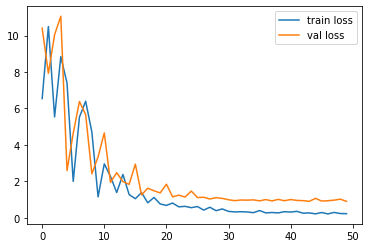

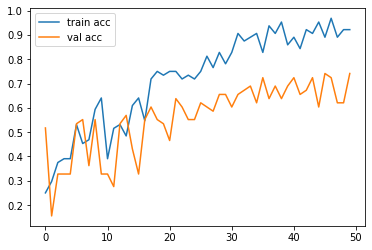

<Figure size 432x288 with 0 Axes>

In [22]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [23]:
# save it as a h5 file


from tensorflow.keras.models import load_model

model.save('model_resnet50.h5')

C:\Users\Admin\anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [28]:

y_pred = model.predict(test_set)


In [29]:
y_pred

array([[4.82745245e-02, 8.70532334e-01, 8.11932012e-02],
       [5.37360925e-03, 9.67103481e-01, 2.75229663e-02],
       [2.12761000e-01, 5.45346916e-01, 2.41892055e-01],
       [1.26569150e-02, 3.13784778e-01, 6.73558354e-01],
       [4.88490969e-01, 4.16372210e-01, 9.51368660e-02],
       [1.66814066e-02, 8.68718505e-01, 1.14600115e-01],
       [4.08001356e-02, 5.54547787e-01, 4.04652059e-01],
       [8.29953909e-01, 1.39321506e-01, 3.07245236e-02],
       [3.99706036e-01, 9.88488719e-02, 5.01445055e-01],
       [1.55457743e-02, 9.68726099e-01, 1.57282352e-02],
       [8.94168578e-03, 9.90360618e-01, 6.97724347e-04],
       [2.25352938e-03, 9.89666820e-01, 8.07972066e-03],
       [1.30073383e-01, 7.37504363e-01, 1.32422149e-01],
       [7.28852209e-03, 3.26513916e-01, 6.66197598e-01],
       [8.06903020e-02, 3.85572091e-02, 8.80752444e-01],
       [3.63227539e-02, 7.59957552e-01, 2.03719750e-01],
       [4.30765897e-02, 5.72661996e-01, 3.84261429e-01],
       [6.54414222e-02, 3.44267

In [30]:
##argmax - choose that index that has the highest probability (from above values of prediction)

import numpy as np
y_pred = np.argmax(y_pred, axis=1)

In [32]:
y_pred

array([1, 1, 1, 2, 0, 1, 1, 0, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 0,
       2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 0, 2, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 0, 1, 1], dtype=int64)

In [33]:
###Predicting the brand of a new car image


from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [34]:
model=load_model('model_resnet50.h5')

In [37]:
pwd

'F:\\DL Project'

In [60]:
img=image.load_img('Datasets/Test/audi/test2.jpg',target_size=(224,224))



In [61]:
x=image.img_to_array(img)
x

array([[[143., 139., 136.],
        [109., 105., 102.],
        [174., 170., 167.],
        ...,
        [ 77.,  67.,  66.],
        [249., 241., 239.],
        [224., 216., 214.]],

       [[104., 100.,  97.],
        [119., 115., 112.],
        [154., 150., 147.],
        ...,
        [ 86.,  76.,  75.],
        [255., 248., 246.],
        [227., 219., 217.]],

       [[104., 100.,  97.],
        [119., 115., 112.],
        [154., 150., 147.],
        ...,
        [ 86.,  76.,  75.],
        [255., 248., 246.],
        [227., 219., 217.]],

       ...,

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [254., 255., 250.],
        [254., 255., 249.],
        [254., 255., 249.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [254., 255., 250.],
        [254., 255., 249.],
        [254., 255., 249.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 2

In [62]:
x.shape

(224, 224, 3)

In [63]:
##Because rescaling has been done as a part of data augmentation for test dataset

x=x/255

In [64]:
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [65]:
model.predict(img_data)

array([[1.2703866e-04, 9.1609298e-05, 9.9978131e-01]], dtype=float32)

In [66]:
a=np.argmax(model.predict(img_data), axis=1)

In [67]:
a==2

array([ True])